# Introduction

The concepts of likelihood, log likelihood, and maximizing log likelihood are important foundations for algorithms used in generative AI, which is a branch of deep learning.

See, also


https://www.statlect.com/glossary/log-likelihood


https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/5-probability.ipynb


Overall,
https://github.com/jonkrohn/ML-foundations/tree/master
is an excellent resource


These foundation concepts are important for understanding:
https://yang-song.net/blog/2021/score/

In [ ]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

# This doesn't seem to fix equation numbering.

In [ ]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

In [18]:
def gaussian(mu, sigma, range, res):
    x = np.array([])
    y = np.array([])
    for x1 in np.arange(mu - range/2, mu + range/2, res):
        y_for_x = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x1 - mu)**2 / (2 * sigma**2) )
        x = np.append(x, x1)
        y = np.append(y, y_for_x)

    return x, y

def log_of_gaussian(mu, sigma, range, res):
    x = np.array([])
    y = np.array([])
    for x1 in np.arange(mu - range/2, mu + range/2, res):

        y_for_x = -np.log(sigma) - 0.5 * np.log(2 * np.pi) - (x1 - mu)**2 / (2 * sigma**2)

        x = np.append(x, x1)
        y = np.append(y, y_for_x)

    return x, y



# Likelihood

Let $\xi$ be a sample of observed data consisting of a set of datapoints:  

$$
\begin{equation}

\xi = [x_1, x_2 ... x_n]

\end{equation}
$$

Let $p(x_i)$ be a probability distribution for a datapoint, $x_i$, in $\xi$.
In ML models, such distributions are parameterized according to a parameter vector, $\theta$, so the distribution is written as $p(\theta, x_i)$.

The likelihood, $L(\theta, \xi)$ is the joint probability of all the datapoints in the sample:

$$
\begin{equation}

L(\theta, \xi) = \prod_{i = 1}^{n} p(\theta, x_i)

\end{equation}
$$

The log likelihood is then

$$
\begin{equation}

\ln L(\theta, \xi) = \ln \prod_{i = 1}^{n} p(\theta, x_i) = \sum_{i = 1}^{n} \ln p(\theta, x_i)

\end{equation}
$$


The log likelihood function is typically used to compute the \textit{maximum likelihood estimator} for a sample.  This is the value of $\theta$ that maximizes the log likelihood:

$$
\begin{equation}

\hat{\theta} = \argmax_{\theta} \ln L(\theta, \xi)

\end{equation}
$$

The log frequently used in maximum likelihood computations because it converts the product of distributions into a sum.  This is convenient for two reasons:  1) the asymptotic properties of sums are easier to analyze; and 2) sums are more numerically stable.

Consider, for example, the case where $p(\theta, x_i)$ is Gaussian (normal):

$$
\begin{equation}

p(\theta, x_i) = \left( 2 \pi \sigma^2 \right) ^ {-1/2} \exp \left( - \frac{1}{2} \frac{\left(x_i - \mu \right)^2}{\sigma^2} \right)

\end{equation}
$$

In this case, $\theta = \left[ \mu \quad \sigma^2 \right]$.

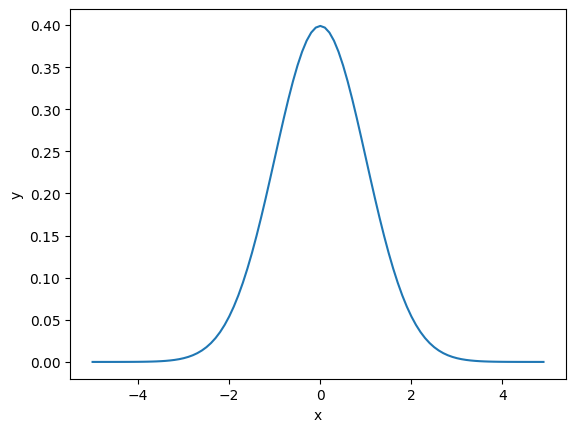

In [16]:
x1, y1 = gaussian(0, 1.0, 10.0, 0.1)
plt.plot(x1, y1)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

For this distribution,

$$
\begin{equation}

\ln p(\theta, x_i) = \ln \left( \left( 2 \pi \sigma^2 \right) ^ {-1/2} \exp \left( - \frac{1}{2} \frac{\left(x_i - \mu \right)^2}{\sigma^2} \right) \right) = \ln \left( 2 \pi \sigma^2 \right) ^ {-1/2} + \ln \left( \exp \left( - \frac{1}{2} \frac{\left(x_i - \mu \right)^2}{\sigma^2} \right) \right) = - \ln ( \sigma ) - \frac{1}{2} \ln (2 \pi) - \frac{(x - \mu)^2}{2 \sigma ^2}

\end{equation}
$$

(see, also, https://stats.stackexchange.com/questions/404191/what-is-the-log-of-the-pdf-for-a-normal-distribution)

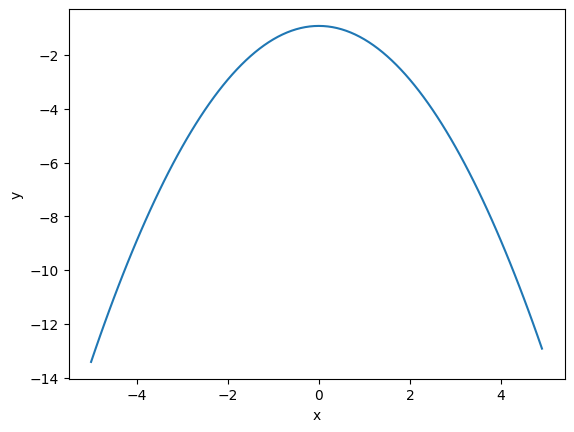

In [19]:
x1, y1 = log_of_gaussian(0, 1.0, 10.0, 0.1)
plt.plot(x1, y1)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Note that this is a parabola, with it's peak (maximum point) at $\mu$.  Therefore, if a sample $\xi$, had only one datapoint, then the argmax operator for computing the maximum likelihood would set $\mu$ to the value of that datapoint.  Note, also, that the gradients of the parabola are lines that point to the optimum.  Thus, a numerical algorithm for maximizing $\mu$ that uses these derivatives would converge to the maximum. 

# Generative Modeling by Estimating Gradients of the Data Distribution

See https://yang-song.net/blog/2021/score/

Many generative modeling approaches, like Variational Auto Encoders, learn probability distributions via (approximate) maximum likelihood.  They then draw samples from these distributions (the generative aspect).  However, learning probability distributions directly can be challenging because the probability, $p_{\theta}(x)$, must be normalized (it must integrate to 1).  This is often computationally difficult.  (Note that $p_{\theta}(x)$ is the same as $p(\theta, \xi)$ in the above discussion).

Generally, the probability is of the form

$$
\begin{equation}

p_{\theta}(x) = \frac{e^{-f_\theta(x)}}{Z_\theta}

\end{equation}
$$

Note that with this general form, a Gaussian probability distribution is represented using $ Z_\theta = \left( 2 \pi \sigma^2 \right) $, and $ f_\theta(x) = \left( - \frac{1}{2} \frac{\left(x_i - \mu \right)^2}{\sigma^2} \right)$, ($\mu$ and $\sigma$ are elements of $\theta$).

For general probability distributions (but not Gaussian ones), computing $Z_\theta$ is often difficult.  An alternative that circumvents this problem is to model _the gradient of the log probability density function_.  This quantity is known as the (Stein) score function.  Such __score-based models__ are not required to have a tractable normalizing constant.  They can be directly learned using an approach called __score matching__.

The score function is defined as $ \nabla_x \ln p(x) $, and the score-based model, $s_\theta(x)$, is learned so that

$$
\begin{equation}

s_\theta(x) \approx \nabla_x \ln p(x) 

\end{equation}
$$

For the above general probability distribution

$$
\begin{equation}

 \ln p_\theta(x) = \ln \left( \exp \left( -f_\theta(x) \right) \right) - \ln \left(  Z_\theta \right) = -f_\theta(x) - \ln \left(  Z_\theta \right)

\end{equation}
$$

(the log of a fraction is the log of the numerator - the log of the denominator).  Taking the gradient yields

$$
\begin{equation}

 \nabla_x \ln p_\theta(x) = -\nabla_x \left( f_\theta(x) \right) - \nabla_x \ln \left(  Z_\theta \right) = -\nabla_x \left( f_\theta(x) \right)

\end{equation}
$$



$$
\begin{equation}

 \ln p_\theta(x) = \ln \left( \exp \left( - \frac{1}{2} \frac{\left(x_i - \mu \right)^2}{\sigma^2} \right) \right) - \ln \left(  2 \pi \sigma^2 \right)

\end{equation}
$$

